# Tiling

In this notebook example, we'll take a look at Datumaro `TileTransform` which is a useful dataset transformation for enhancing [small object detection tasks](https://openaccess.thecvf.com/content_CVPRW_2019/papers/UAVision/Unel_The_Power_of_Tiling_for_Small_Object_Detection_CVPRW_2019_paper.pdf). We are going to look at the example codes for object detection task with [Six-sided Dice Dataset](https://github.com/nell-byler/dice_detection).

## Prerequisite
### Download Six-sided Dice dataset
This is [a download link for Six-sided Dice dataset in Kaggle](https://www.kaggle.com/datasets/nellbyler/d6-dice?resource=download). Please download using this link and extract to your workspace directory. Then, you will have a `d6-dice` directory with annotations and images in YOLO format as follows.

```bash
d6-dice
├── Annotations
│   ├── classes.txt
│   ├── IMG_20191208_111228.txt
│   ├── IMG_20191208_111246.txt
│   ├── ...
└── Images
    ├── IMG_20191208_111228.jpg
    ├── IMG_20191208_111246.jpg
    ├── ...
```

However, for import compatibility, `obj.names` file must be added to `d6-dice/obj.names` filepath for import compatibility. This `obj.names` file includes the label names of the dataset, e.g., `[dice1, ..., dice6]`. Therefore, you can write it with the following simple code. Please see [Yolo Loose format](https://openvinotoolkit.github.io/datumaro/docs/formats/yolo/) for more details.

In [1]:
# Copyright (C) 2023 Intel Corporation
#
# SPDX-License-Identifier: MIT

import os

root_dir = "d6-dice"

names = """
dice1
dice2
dice3
dice4
dice5
dice6
"""

fpath = os.path.join(root_dir, "obj.names")
with open(fpath, "w") as fp:
    fp.write(names)

## Import dataset

Firstly, we import this dataset using Datumaro Python API.

In [2]:
from datumaro import Dataset


def get_ids(dataset: Dataset, subset: str):
    ids = []
    for item in dataset:
        if item.subset == subset:
            ids += [item.id]

    return ids


dataset = Dataset.import_from("./d6-dice", format="yolo")
subset = "default"
ids = get_ids(dataset, subset)

dataset

Dataset
	size=250
	source_path=./d6-dice
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=250
	annotations_count=1795
subsets
	default: # of items=250, # of annotated items=250, # of annotations=1795, annotation types=['bbox']
infos
	categories
	label: ['dice1', 'dice2', 'dice3', 'dice4', 'dice5', 'dice6']

Let's take a closer look at one of the samples using Visualizer. This sample contains a high-resolution image and several small objects.

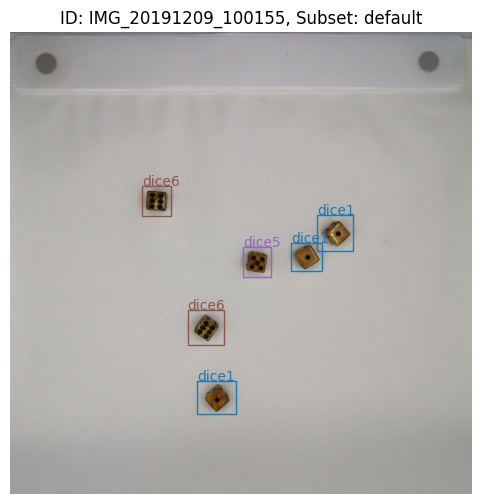

In [3]:
from datumaro.components.visualizer import Visualizer

target_id = ids[10]
vizualizer = Visualizer(dataset, alpha=0.7)
fig = vizualizer.vis_one_sample(target_id, subset)
fig.show()

After a tiling transformation in the dataset, the previous samples are split into 2x2 slices of tiled samples.

In [4]:
from datumaro.plugins.tiling import Tile

tiled_dataset = dataset.transform(
    Tile, grid_size=(2, 2), overlap=(0.1, 0.1), threshold_drop_ann=0.5
)
target_ids = [tiled_id for tiled_id in get_ids(tiled_dataset, subset) if target_id in tiled_id]
print(target_ids)

['IMG_20191209_100155_tile_0', 'IMG_20191209_100155_tile_1', 'IMG_20191209_100155_tile_2', 'IMG_20191209_100155_tile_3']


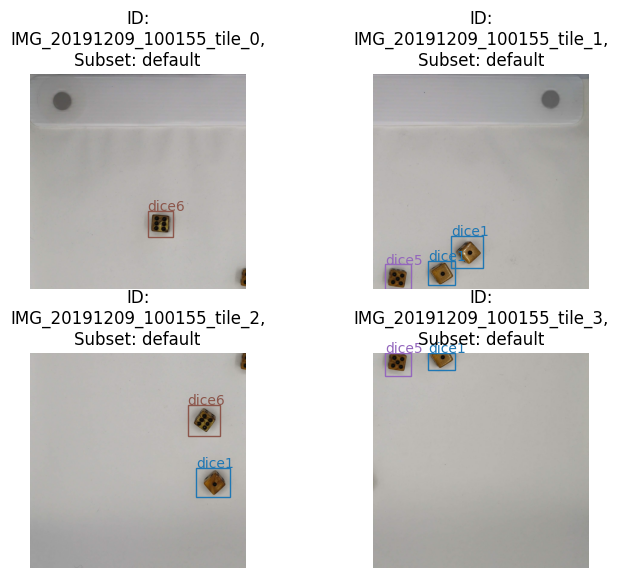

In [5]:
vizualizer = Visualizer(tiled_dataset, alpha=0.7)
fig = vizualizer.vis_gallery(target_ids, subset)
fig.tight_layout(pad=3.0)
fig.show()

## Export tile transformed dataset

Next, we will export the transformed dataset for the next machine learning workflow. The following code will export the dataset in `d6-dice-coco` path with `COCO` format.

> **You should set `save_media=True` to save the tiled image also.**

In [6]:
tiled_dataset.export("d6-dice-tiled-coco", "coco_instances", save_media=True)

Then, we will check whether the dataset export is succesful by importing `d6-dice-coco` dataset again.

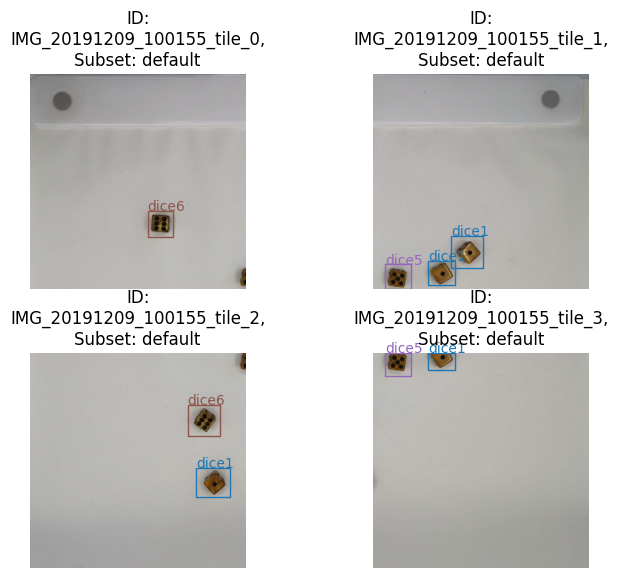

In [7]:
coco_dataset = Dataset.import_from("d6-dice-tiled-coco", "coco_instances")

vizualizer = Visualizer(coco_dataset, alpha=0.7)
fig = vizualizer.vis_gallery(target_ids, subset)
fig.tight_layout(pad=3.0)
fig.show()